In [1]:
import datetime, time
import pytz
import json
import matplotlib.pyplot as plt
import io
from collections import defaultdict
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import KFold
import time
from sklearn.preprocessing import MinMaxScaler
import re


/Users/alicetang/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
tag = '/Users/alicetang/Desktop/study/ECE219/project_5/tweet_data/tweets_#superbowl.txt'

location_Massachusetts = [' Ma$', ' Ma ', 'Massachusetts', 'Boston', 'Cambridge', 'Worcester', 'Marlborough',
                          'Salem', 'Beverly', 'Yarmouth', 'Watertown', 'New Bedford', 'Waltham', 'Natick',
                          'Cape Cod', 'Lowell', 'Quincy', 'Brookline', 'Somerville','Springfield', 'amherst',
                          'framingham']
location_Washington = [' WA$', 'Seattle', 'Washington', 'Kirkland', 'Perth', 'Woodinville', 'Spokane', 'Pullman',
                       'Renton', 'Everett','Puyallup', 'Olympia', 'Redmond', 'Bellevue', 'Bellingham',
                       'Vancouver', 'Tacoma', 'Spokane', 'auburn', 'kennewick', 'kent', 'yakima']
DC_re = ['d.c', 'dc']
texts = list()
locations = list()

f = open(tag, 'rb')
for line in f:
    tweet = json.loads(line)
    word = tweet['tweet']['user']['location']
    
    flag_WA = None
    flag_MA = None
    flag_dc  =None
    
    for re_WA in location_Washington:
        flag_WA = re.search(re_WA, word, re.I)
        if flag_WA:
            for dc in DC_re:
                flag_dc = re.search(dc, word, re.I)
                if flag_dc:
                    flag_WA = None
            break
    for re_MA in location_Massachusetts:
        flag_MA = re.search(re_MA, word, re.I)
        if flag_MA:
            break
    
    if flag_WA is not None and flag_MA is None:
        text = tweet['tweet']['text']
        texts.append(text)
        locations.append(1) 
    if flag_WA is None and flag_MA is not None:
        text = tweet['tweet']['text']
        texts.append(text)
        locations.append(0) 


In [3]:
print(len(locations))
print(len(texts))

54812
54812


In [4]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_extraction import text
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import auc, confusion_matrix, recall_score, roc_curve, precision_score, accuracy_score
import itertools


In [5]:
stop_words = text.ENGLISH_STOP_WORDS

def stem_tokenizer(text):
    stemmer = SnowballStemmer("english")
    text_new = re.sub('[^a-zA-Z]',' ',text)
    text_new = text_new.lower()
    words = text_new.split()
    stemmed = [stemmer.stem(item) for item in words]
    words_new = []
    for word in stemmed:
        if re.search('[a-z]{2,}',word):
            words_new.append(word)
    return words_new

def produce_pipeline(MIN_DF, CLF):
    pipe = Pipeline([('vect', CountVectorizer(analyzer = 'word', tokenizer = stem_tokenizer, stop_words = stop_words, min_df = MIN_DF)),
                     ('tfidf', TfidfTransformer()),
                     ('reduce_dim', NMF(n_components = 50, init = 'random', random_state = 0)),
                     ('clf', CLF)])
    return pipe

def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)
    
    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)
    ax.set_title('ROC Curve')

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix without Normalization')
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '%.2f' % cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j]>thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def compute_and_plot_confusion_matrix(test_label, test_predicted):
    cnf_matrix = confusion_matrix(test_label, test_predicted)
    np.set_printoptions(precision = 2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes = bclasses, title = 'Confusion Matrix without Normalization')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes = bclasses, normalize = True, title = 'Normalized Confusion Matrix')
    plt.show()

Confusion Matrix without Normalization
[[1040 1587]
 [ 167 2688]]
Normalized Confusion Matrix
[[ 0.4   0.6 ]
 [ 0.06  0.94]]


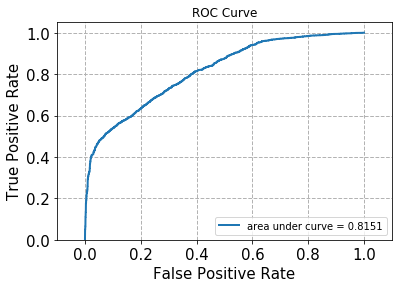

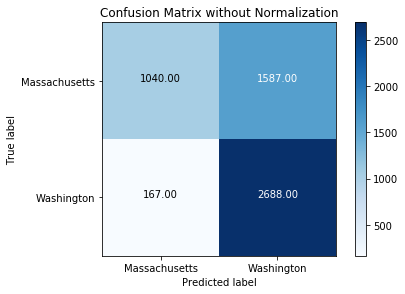

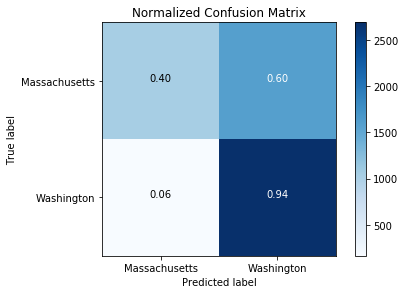

Accuracy: 0.680043779642
Recall: 0.941506129597
Precision: 0.628771929825
------------------------------
Confusion Matrix without Normalization
[[ 666 1937]
 [  62 2817]]
Normalized Confusion Matrix
[[ 0.26  0.74]
 [ 0.02  0.98]]


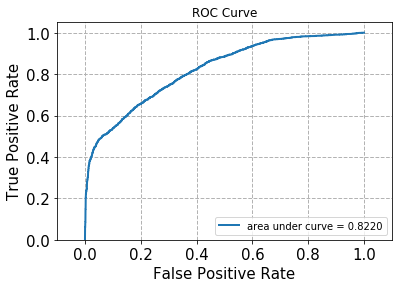

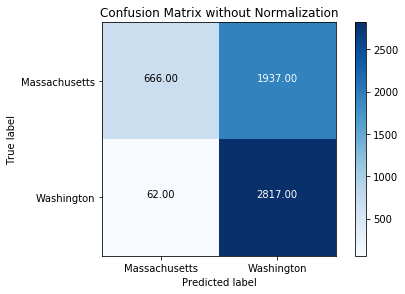

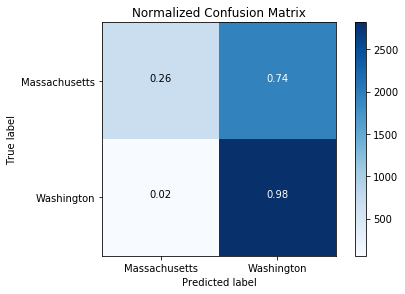

Accuracy: 0.635352061291
Recall: 0.978464744703
Precision: 0.592553639041
------------------------------
Confusion Matrix without Normalization
[[ 765 1801]
 [  74 2841]]
Normalized Confusion Matrix
[[ 0.3   0.7 ]
 [ 0.03  0.97]]


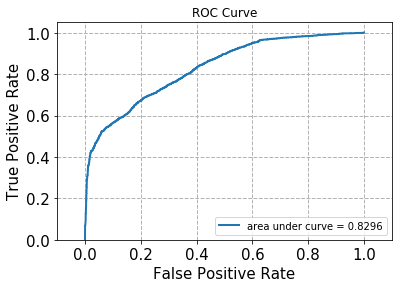

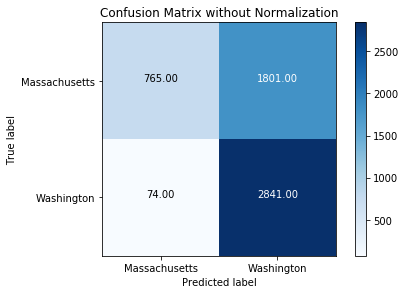

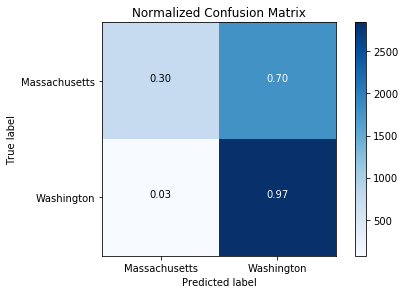

Accuracy: 0.657909140668
Recall: 0.97461406518
Precision: 0.612020680741
------------------------------
Confusion Matrix without Normalization
[[1025 1606]
 [ 118 2732]]
Normalized Confusion Matrix
[[ 0.39  0.61]
 [ 0.04  0.96]]


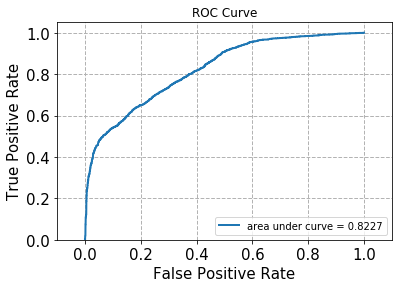

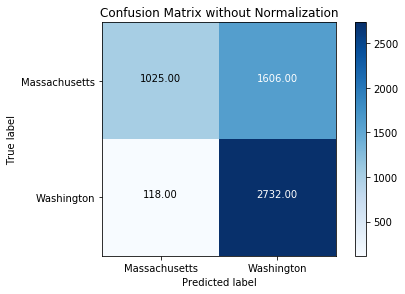

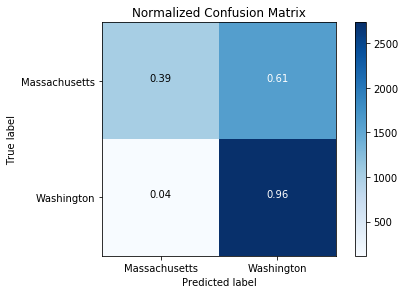

Accuracy: 0.685458857873
Recall: 0.958596491228
Precision: 0.629783310281
------------------------------
Confusion Matrix without Normalization
[[ 413 2242]
 [  42 2784]]
Normalized Confusion Matrix
[[ 0.16  0.84]
 [ 0.01  0.99]]


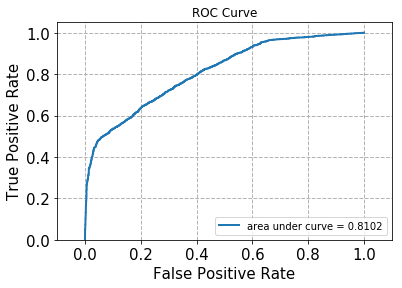

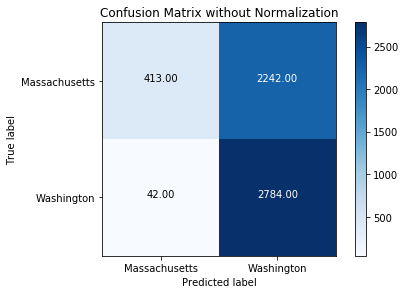

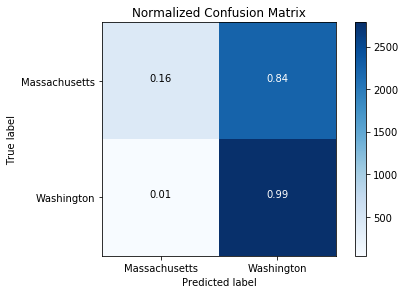

Accuracy: 0.583287721219
Recall: 0.985138004246
Precision: 0.553919617986
------------------------------
Confusion Matrix without Normalization
[[ 684 1945]
 [  75 2777]]
Normalized Confusion Matrix
[[ 0.26  0.74]
 [ 0.03  0.97]]


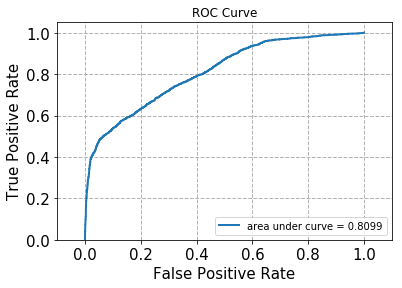

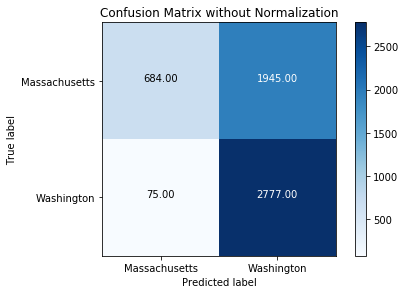

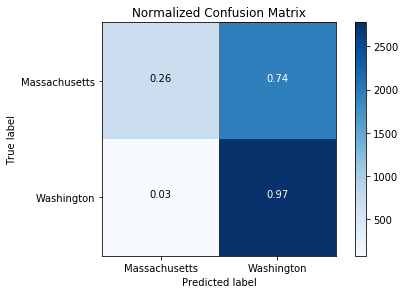

Accuracy: 0.631454114213
Recall: 0.973702664797
Precision: 0.588098263448
------------------------------
Confusion Matrix without Normalization
[[2526  102]
 [1546 1307]]
Normalized Confusion Matrix
[[ 0.96  0.04]
 [ 0.54  0.46]]


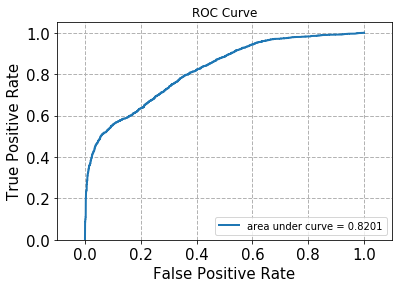

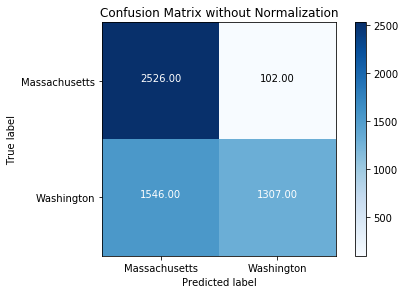

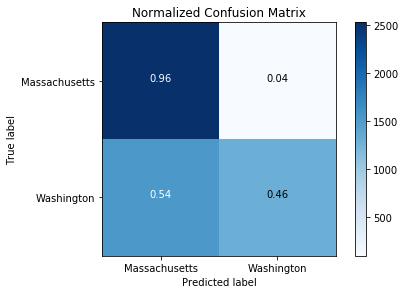

Accuracy: 0.699324940704
Recall: 0.458114265685
Precision: 0.927608232789
------------------------------
Confusion Matrix without Normalization
[[2588   45]
 [1772 1076]]
Normalized Confusion Matrix
[[ 0.98  0.02]
 [ 0.62  0.38]]


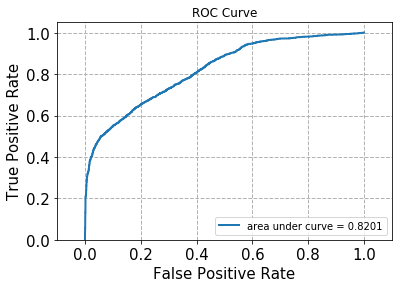

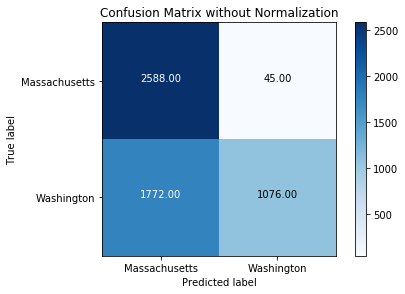

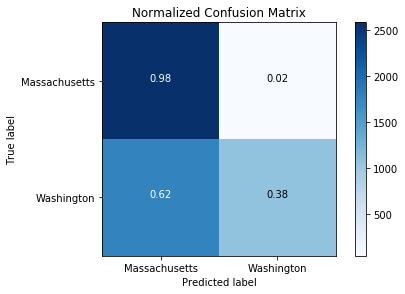

Accuracy: 0.66849115125
Recall: 0.377808988764
Precision: 0.959857270294
------------------------------
Confusion Matrix without Normalization
[[ 507 2139]
 [  37 2798]]
Normalized Confusion Matrix
[[ 0.19  0.81]
 [ 0.01  0.99]]


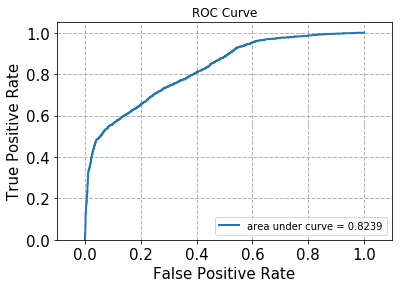

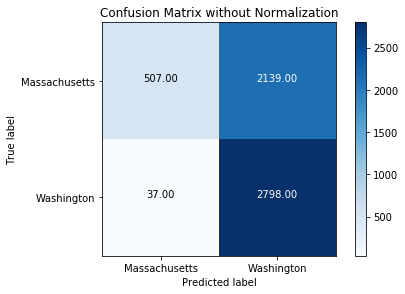

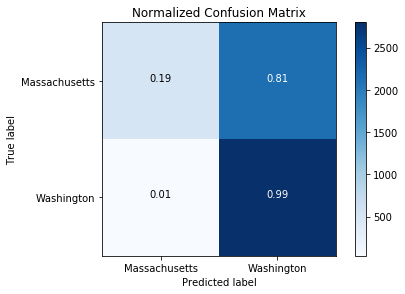

Accuracy: 0.602992154716
Recall: 0.986948853616
Precision: 0.566740935791
------------------------------
Confusion Matrix without Normalization
[[ 386 2257]
 [  29 2809]]
Normalized Confusion Matrix
[[ 0.15  0.85]
 [ 0.01  0.99]]


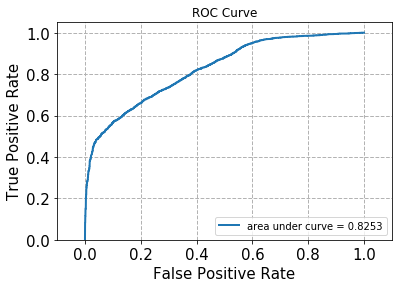

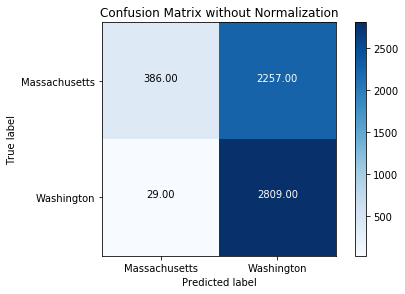

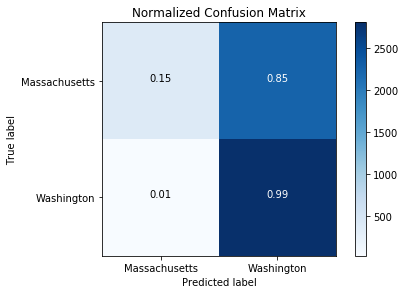

Accuracy: 0.582922824302
Recall: 0.989781536293
Precision: 0.554480852744
------------------------------
The average accuracy is 0.6427
The average recall is 0.8625
The average precision is 0.6614
Runtime：755.263


In [6]:
start = time.clock()

X = np.array(texts)
y = np.array(locations)

vect_2 = CountVectorizer(analyzer = 'word', tokenizer = stem_tokenizer, stop_words = stop_words, min_df = 2)
tfidf_transformer = TfidfTransformer()

pipe = produce_pipeline(2, LinearSVC(C = 1000))

bclasses = ['Massachusetts','Washington']

accuracies = list()
recalls = list()
precisions = list()

kf = KFold(n_splits=10, random_state=42, shuffle=True)
for train_index, test_index in kf.split(texts):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = list(X_train)
    y_train = list(y_train)
    X_test = list(X_test)
    y_test = list(y_test)
    
    pipe.fit(X_train, y_train)
    
    test_score = pipe.decision_function(X_test)
    
    test_predict = pipe.predict(X_test)
    
    fpr, tpr, threshold = roc_curve(y_test, test_score)
    
    plot_roc(fpr, tpr)
    compute_and_plot_confusion_matrix(y_test, test_predict)
    
    accuracy = accuracy_score(y_test, test_predict)
    accuracies.append(accuracy)
    print('Accuracy:',accuracy)
    
    recall = recall_score(y_test, test_predict)
    recalls.append(recall)
    print('Recall:',recall)
    
    precision = precision_score(y_test, test_predict)
    precisions.append(precision)
    print('Precision:',precision)
    
    print('-'*30)

print('The average accuracy is %.4f'%(sum(accuracies)/len(accuracies)))
print('The average recall is %.4f'%(sum(recalls)/len(recalls)))
print('The average precision is %.4f'%(sum(precisions)/len(precisions)))
    
end = time.clock()
print("Runtime：%.03f"%(end - start))

In [7]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression

Confusion Matrix without Normalization
[[1379  165]
 [ 533 3405]]
Normalized Confusion Matrix
[[ 0.89  0.11]
 [ 0.14  0.86]]


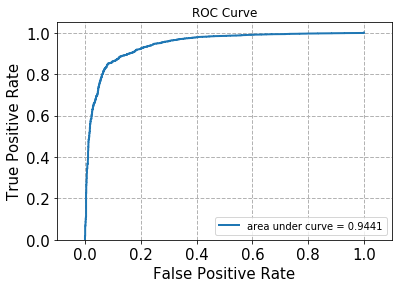

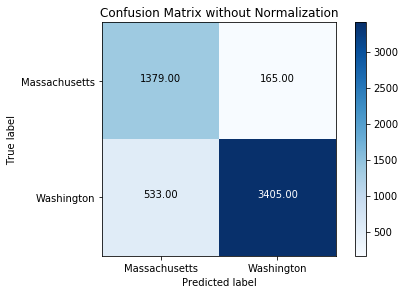

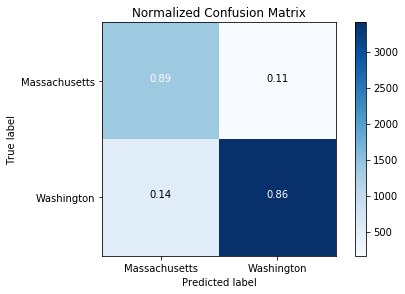

Accuracy: 0.872674206494
Recall: 0.864652107669
Precision: 0.953781512605
------------------------------
Confusion Matrix without Normalization
[[1241  855]
 [ 266 3120]]
Normalized Confusion Matrix
[[ 0.59  0.41]
 [ 0.08  0.92]]


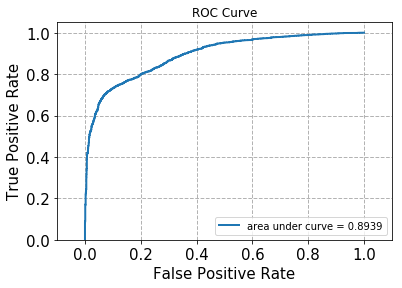

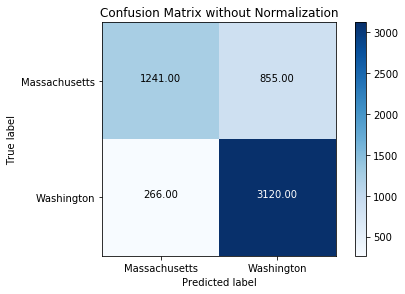

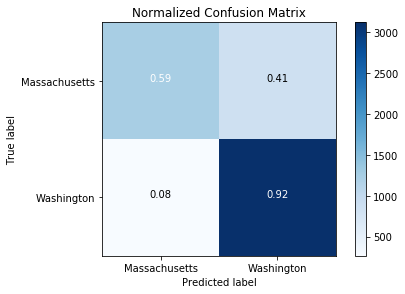

Accuracy: 0.795512586647
Recall: 0.921441228588
Precision: 0.784905660377
------------------------------
Confusion Matrix without Normalization
[[ 588 2255]
 [  37 2601]]
Normalized Confusion Matrix
[[ 0.21  0.79]
 [ 0.01  0.99]]


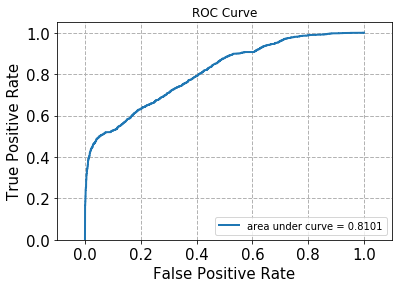

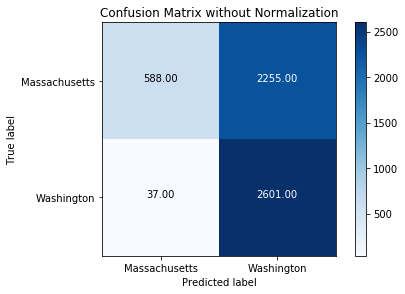

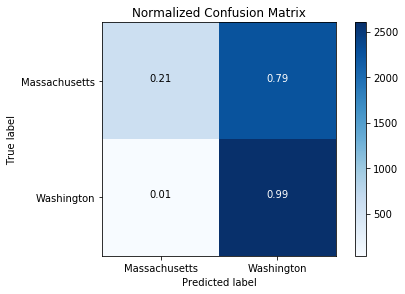

Accuracy: 0.581828133552
Recall: 0.985974222896
Precision: 0.535626029654
------------------------------
Confusion Matrix without Normalization
[[1077 1275]
 [ 131 2998]]
Normalized Confusion Matrix
[[ 0.46  0.54]
 [ 0.04  0.96]]


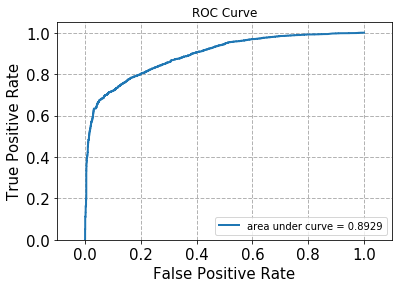

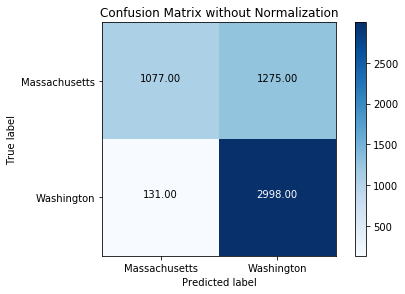

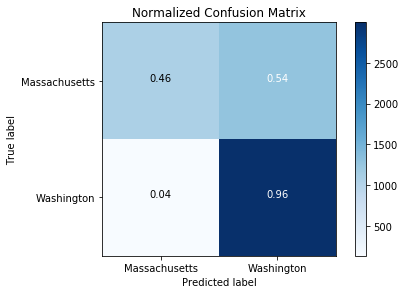

Accuracy: 0.743477467615
Recall: 0.958133589006
Precision: 0.701614790545
------------------------------
Confusion Matrix without Normalization
[[ 712 1907]
 [ 165 2697]]
Normalized Confusion Matrix
[[ 0.27  0.73]
 [ 0.06  0.94]]


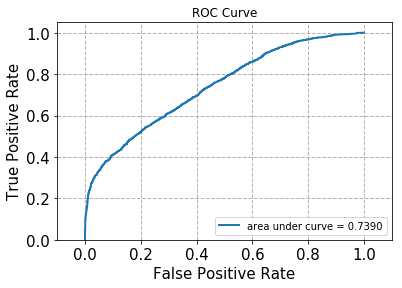

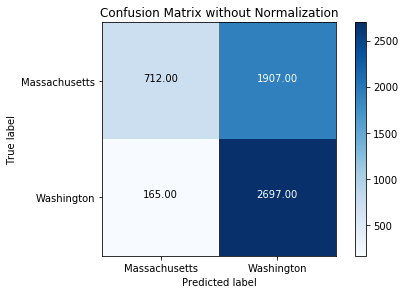

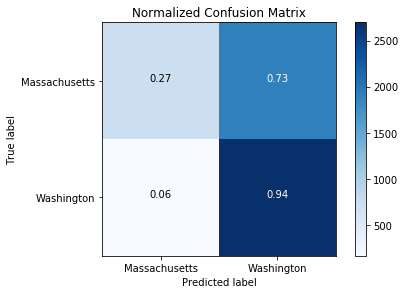

Accuracy: 0.621966794381
Recall: 0.942348008386
Precision: 0.585794960904
------------------------------
Confusion Matrix without Normalization
[[ 569 2383]
 [  96 2433]]
Normalized Confusion Matrix
[[ 0.19  0.81]
 [ 0.04  0.96]]


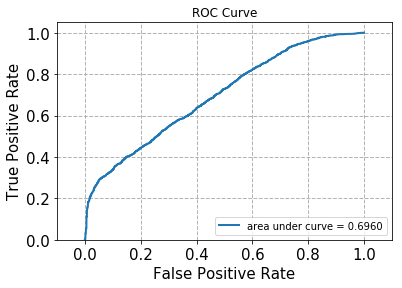

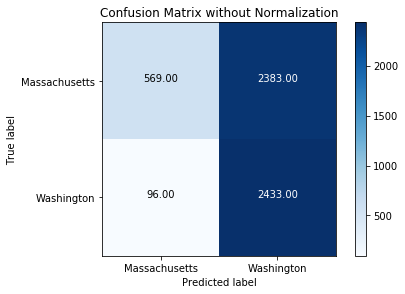

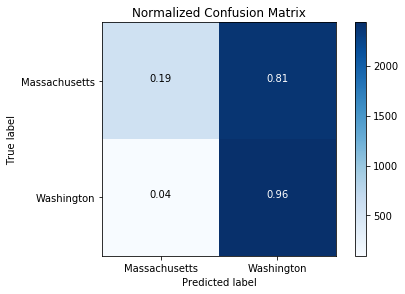

Accuracy: 0.547710271848
Recall: 0.962040332147
Precision: 0.5051910299
------------------------------
Confusion Matrix without Normalization
[[ 431 2171]
 [ 318 2561]]
Normalized Confusion Matrix
[[ 0.17  0.83]
 [ 0.11  0.89]]


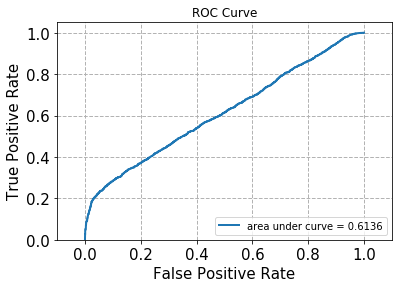

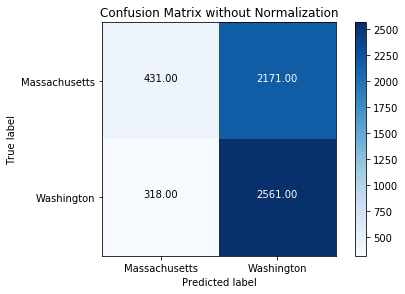

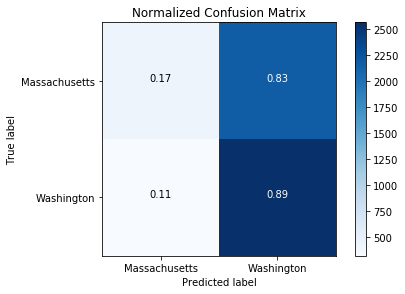

Accuracy: 0.545885787265
Recall: 0.889544980896
Precision: 0.541208791209
------------------------------
Confusion Matrix without Normalization
[[ 554 1912]
 [ 182 2833]]
Normalized Confusion Matrix
[[ 0.22  0.78]
 [ 0.06  0.94]]


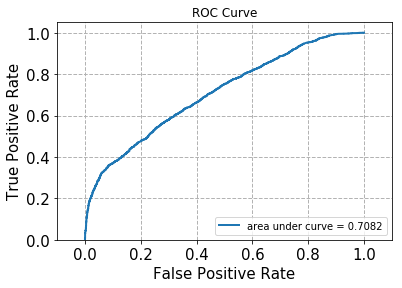

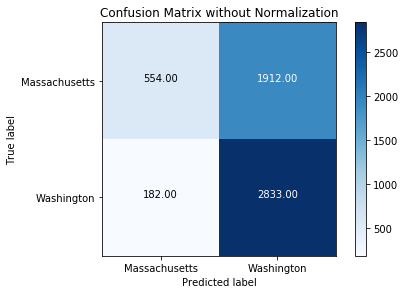

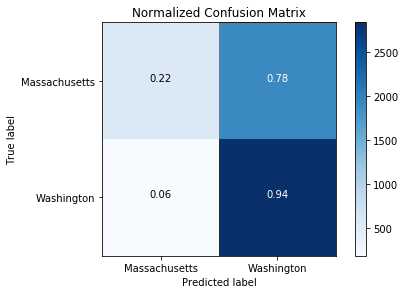

Accuracy: 0.617952928298
Recall: 0.939635157546
Precision: 0.597049525817
------------------------------
Confusion Matrix without Normalization
[[ 904 2327]
 [ 117 2133]]
Normalized Confusion Matrix
[[ 0.28  0.72]
 [ 0.05  0.95]]


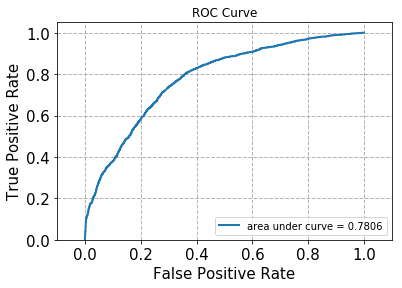

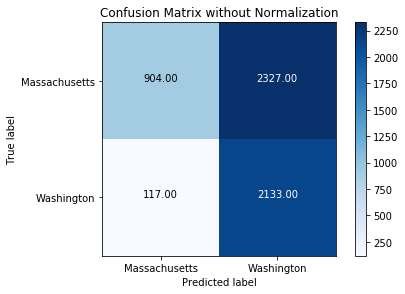

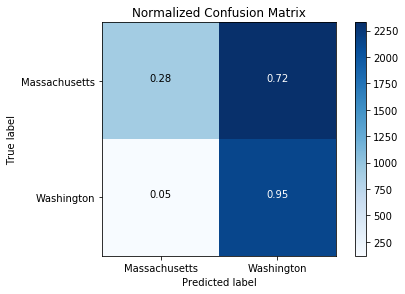

Accuracy: 0.554095967889
Recall: 0.948
Precision: 0.478251121076
------------------------------
Confusion Matrix without Normalization
[[ 495 3061]
 [  24 1901]]
Normalized Confusion Matrix
[[ 0.14  0.86]
 [ 0.01  0.99]]


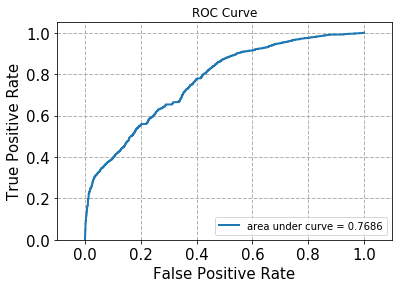

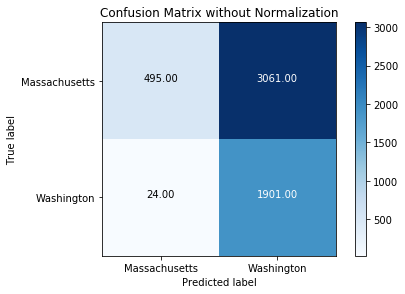

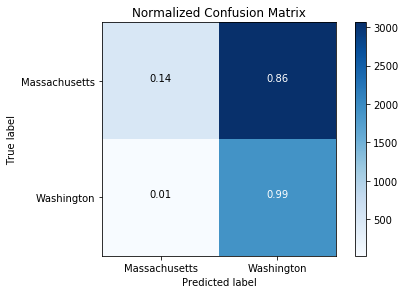

Accuracy: 0.437146506112
Recall: 0.987532467532
Precision: 0.383111648529
------------------------------
The average accuracy is 0.6318
The average recall is 0.9399
The average precision is 0.6067
Runtime：582.221


In [8]:
start = time.clock()

X = np.array(texts)
y = np.array(locations)

vect_2 = CountVectorizer(analyzer = 'word', tokenizer = stem_tokenizer, stop_words = stop_words, min_df = 2)
tfidf_transformer = TfidfTransformer()

pipe = produce_pipeline(2, MultinomialNB())

bclasses = ['Massachusetts','Washington']

accuracies = list()
recalls = list()
precisions = list()

kf = KFold(n_splits=10)
for train_index, test_index in kf.split(texts):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = list(X_train)
    y_train = list(y_train)
    X_test = list(X_test)
    y_test = list(y_test)
    
    pipe.fit(X_train, y_train)
    
    test_score = pipe.predict_proba(X_test)
    
    test_predict = pipe.predict(X_test)
    
    fpr, tpr, threshold = roc_curve(y_test, test_score[:,1])
    
    plot_roc(fpr, tpr)
    compute_and_plot_confusion_matrix(y_test, test_predict)
    
    accuracy = accuracy_score(y_test, test_predict)
    accuracies.append(accuracy)
    print('Accuracy:',accuracy)
    
    recall = recall_score(y_test, test_predict)
    recalls.append(recall)
    print('Recall:',recall)
    
    precision = precision_score(y_test, test_predict)
    precisions.append(precision)
    print('Precision:',precision)
    
    print('-'*30)

print('The average accuracy is %.4f'%(sum(accuracies)/len(accuracies)))
print('The average recall is %.4f'%(sum(recalls)/len(recalls)))
print('The average precision is %.4f'%(sum(precisions)/len(precisions)))

end = time.clock()
print("Runtime：%.03f"%(end - start))

Confusion Matrix without Normalization
[[1236  308]
 [ 449 3489]]
Normalized Confusion Matrix
[[ 0.8   0.2 ]
 [ 0.11  0.89]]


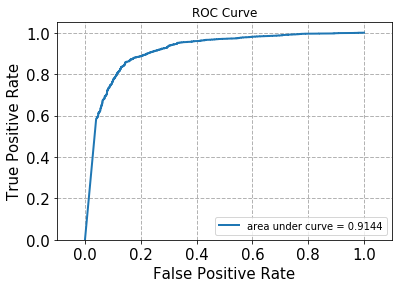

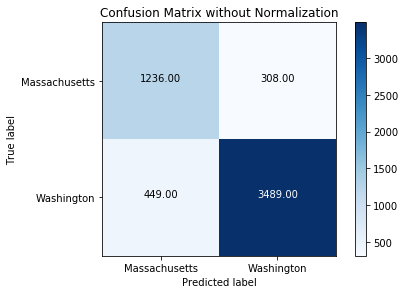

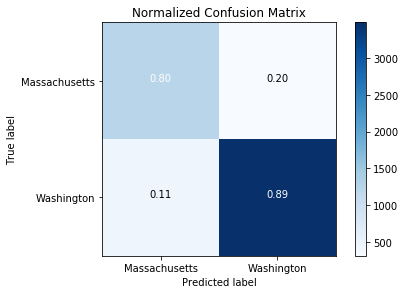

Accuracy: 0.861911711054
Recall: 0.885982732351
Precision: 0.918883328944
------------------------------
Confusion Matrix without Normalization
[[1784  312]
 [ 917 2469]]
Normalized Confusion Matrix
[[ 0.85  0.15]
 [ 0.27  0.73]]


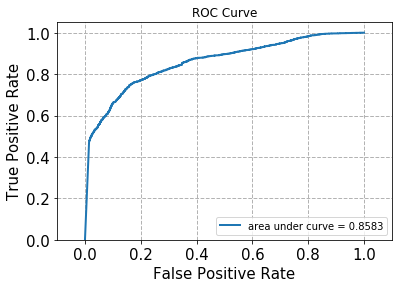

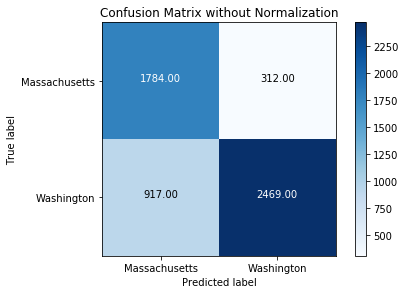

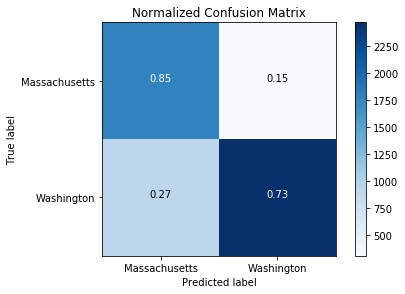

Accuracy: 0.775811747537
Recall: 0.729178972239
Precision: 0.887810140237
------------------------------
Confusion Matrix without Normalization
[[2405  438]
 [1276 1362]]
Normalized Confusion Matrix
[[ 0.85  0.15]
 [ 0.48  0.52]]


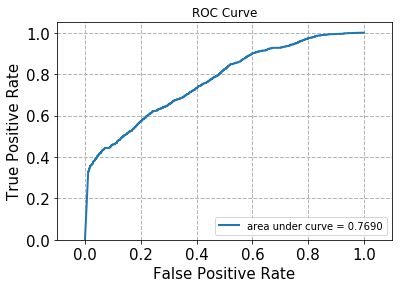

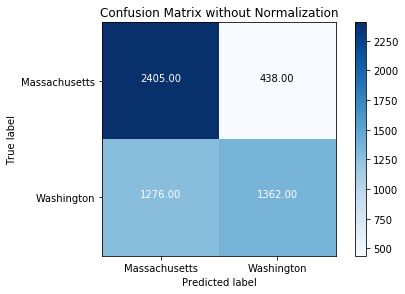

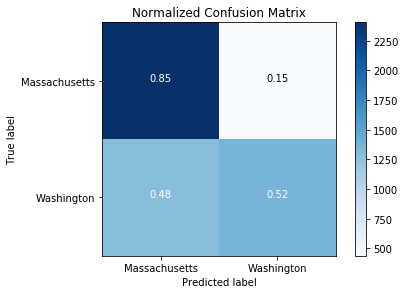

Accuracy: 0.687283342456
Recall: 0.516300227445
Precision: 0.756666666667
------------------------------
Confusion Matrix without Normalization
[[1252 1100]
 [ 250 2879]]
Normalized Confusion Matrix
[[ 0.53  0.47]
 [ 0.08  0.92]]


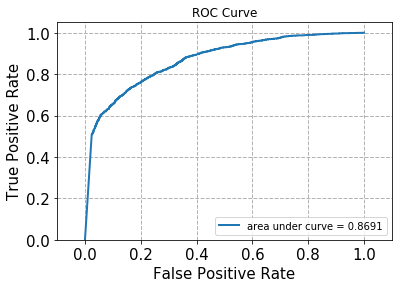

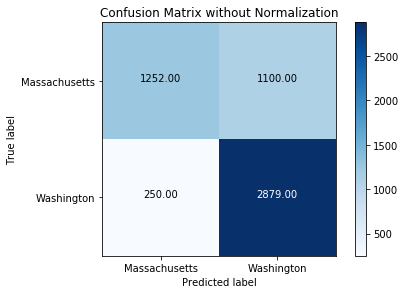

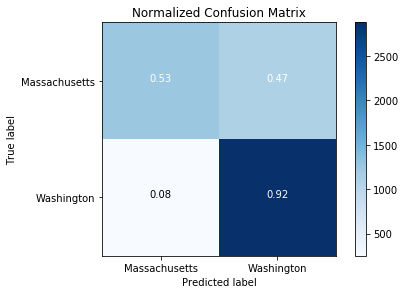

Accuracy: 0.753694581281
Recall: 0.920102269096
Precision: 0.723548630309
------------------------------
Confusion Matrix without Normalization
[[2193  426]
 [1533 1329]]
Normalized Confusion Matrix
[[ 0.84  0.16]
 [ 0.54  0.46]]


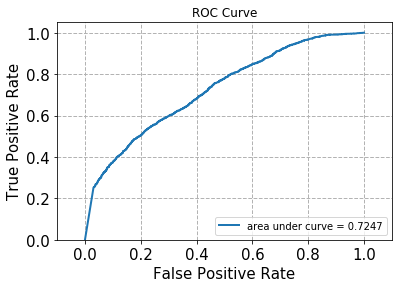

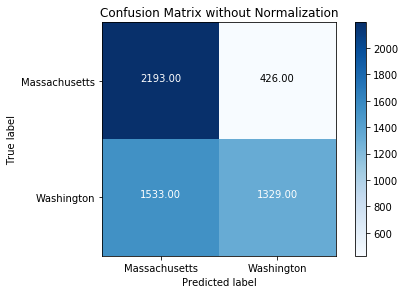

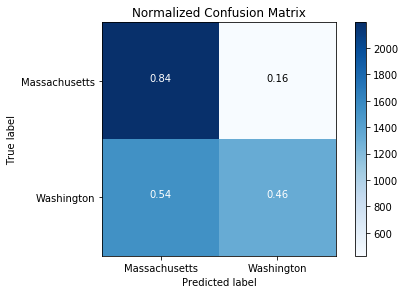

Accuracy: 0.64258347017
Recall: 0.464360587002
Precision: 0.757264957265
------------------------------
Confusion Matrix without Normalization
[[2376  576]
 [1498 1031]]
Normalized Confusion Matrix
[[ 0.8   0.2 ]
 [ 0.59  0.41]]


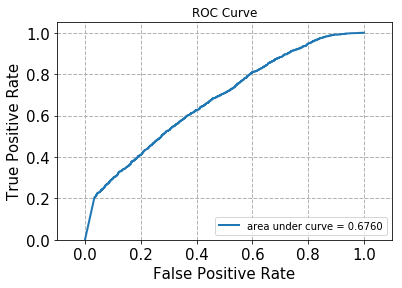

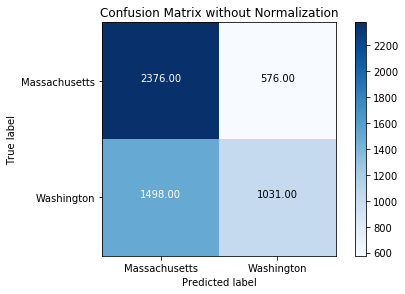

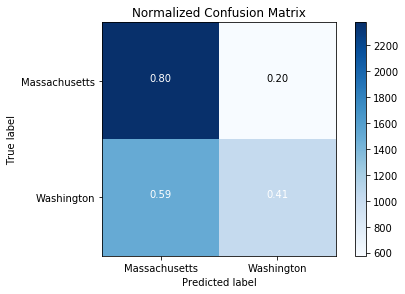

Accuracy: 0.621601897464
Recall: 0.407671016212
Precision: 0.64156813939
------------------------------
Confusion Matrix without Normalization
[[2328  274]
 [2111  768]]
Normalized Confusion Matrix
[[ 0.89  0.11]
 [ 0.73  0.27]]


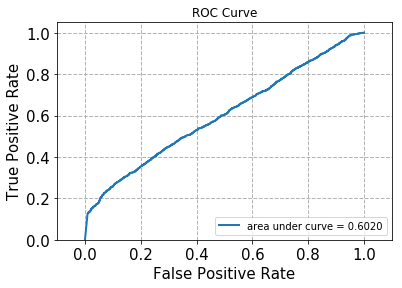

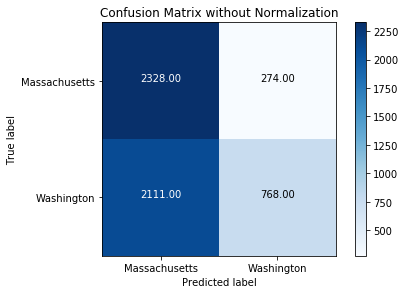

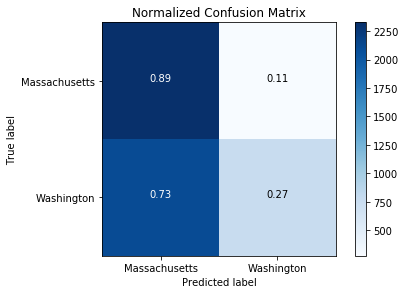

Accuracy: 0.564860426929
Recall: 0.266759291421
Precision: 0.737044145873
------------------------------
Confusion Matrix without Normalization
[[2166  300]
 [1920 1095]]
Normalized Confusion Matrix
[[ 0.88  0.12]
 [ 0.64  0.36]]


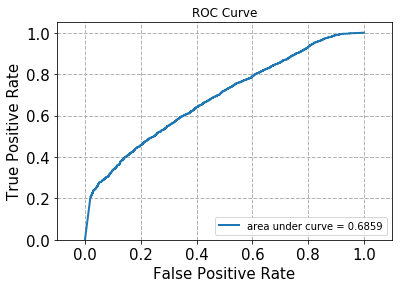

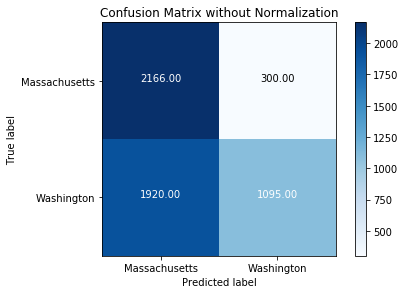

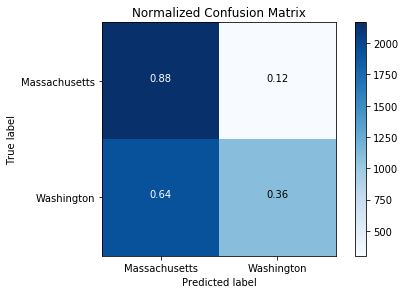

Accuracy: 0.594964422551
Recall: 0.363184079602
Precision: 0.784946236559
------------------------------
Confusion Matrix without Normalization
[[2262  969]
 [ 690 1560]]
Normalized Confusion Matrix
[[ 0.7   0.3 ]
 [ 0.31  0.69]]


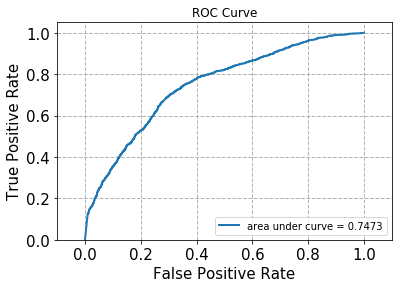

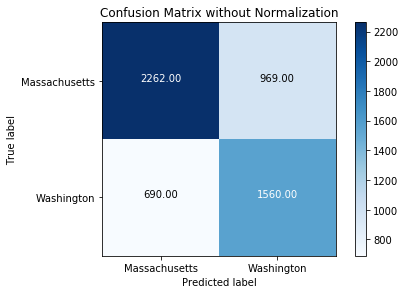

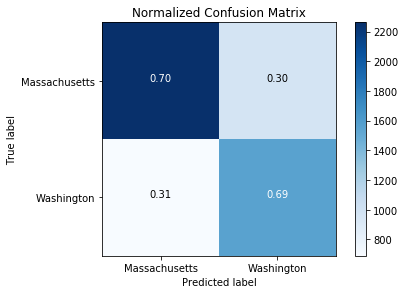

Accuracy: 0.697318007663
Recall: 0.693333333333
Precision: 0.61684460261
------------------------------
Confusion Matrix without Normalization
[[3217  339]
 [1281  644]]
Normalized Confusion Matrix
[[ 0.9   0.1 ]
 [ 0.67  0.33]]


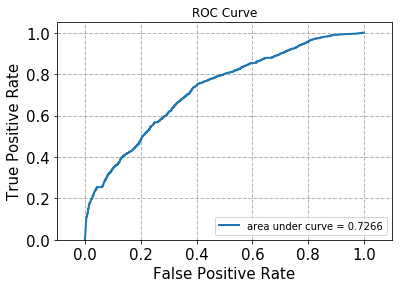

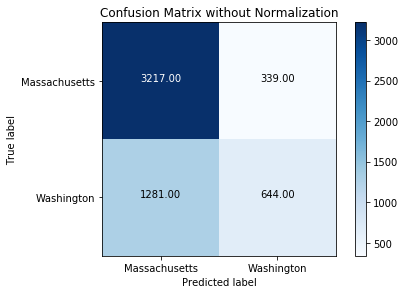

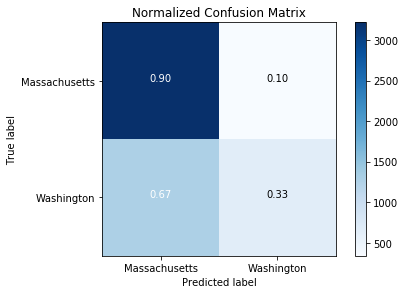

Accuracy: 0.704433497537
Recall: 0.334545454545
Precision: 0.65513733469
------------------------------
The average accuracy is 0.6904
The average recall is 0.5581
The average precision is 0.7480
Runtime：568.007


In [9]:
start = time.clock()

X = np.array(texts)
y = np.array(locations)

vect_2 = CountVectorizer(analyzer = 'word', tokenizer = stem_tokenizer, stop_words = stop_words, min_df = 2)
tfidf_transformer = TfidfTransformer()

pipe = produce_pipeline(2, GaussianNB())

bclasses = ['Massachusetts','Washington']

accuracies = list()
recalls = list()
precisions = list()

kf = KFold(n_splits=10)
for train_index, test_index in kf.split(texts):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = list(X_train)
    y_train = list(y_train)
    X_test = list(X_test)
    y_test = list(y_test)
    
    pipe.fit(X_train, y_train)
    
    test_score = pipe.predict_proba(X_test)
    
    test_predict = pipe.predict(X_test)
    
    fpr, tpr, threshold = roc_curve(y_test, test_score[:,1])
    
    plot_roc(fpr, tpr)
    compute_and_plot_confusion_matrix(y_test, test_predict)
    
    accuracy = accuracy_score(y_test, test_predict)
    accuracies.append(accuracy)
    print('Accuracy:',accuracy)
    
    recall = recall_score(y_test, test_predict)
    recalls.append(recall)
    print('Recall:',recall)
    
    precision = precision_score(y_test, test_predict)
    precisions.append(precision)
    print('Precision:',precision)
    
    print('-'*30)

print('The average accuracy is %.4f'%(sum(accuracies)/len(accuracies)))
print('The average recall is %.4f'%(sum(recalls)/len(recalls)))
print('The average precision is %.4f'%(sum(precisions)/len(precisions)))

end = time.clock()
print("Runtime：%.03f"%(end - start))

Confusion Matrix without Normalization
[[1369  175]
 [ 429 3509]]
Normalized Confusion Matrix
[[ 0.89  0.11]
 [ 0.11  0.89]]


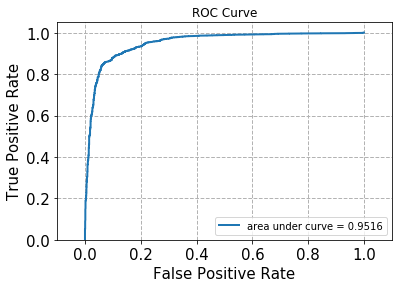

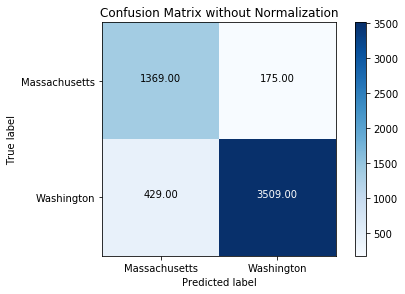

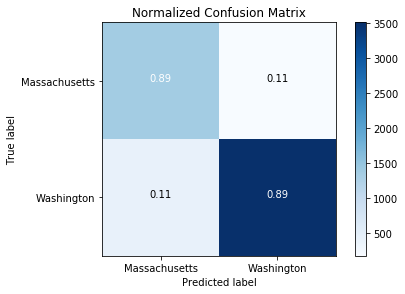

Accuracy: 0.889821233127
Recall: 0.891061452514
Precision: 0.952497285559
------------------------------
Confusion Matrix without Normalization
[[1873  223]
 [ 809 2577]]
Normalized Confusion Matrix
[[ 0.89  0.11]
 [ 0.24  0.76]]


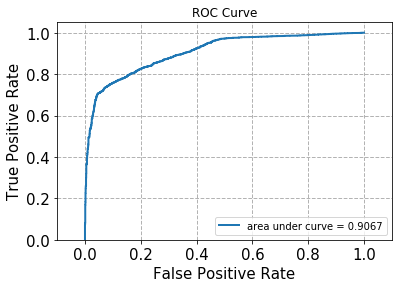

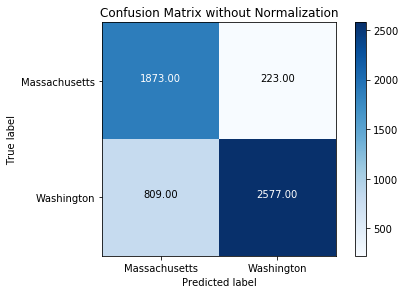

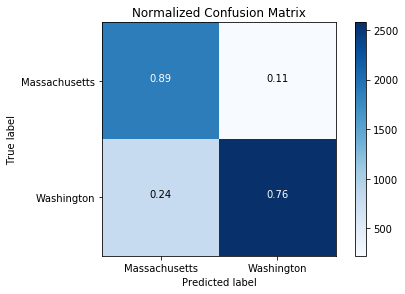

Accuracy: 0.811747537395
Recall: 0.761075014767
Precision: 0.920357142857
------------------------------
Confusion Matrix without Normalization
[[2215  628]
 [ 934 1704]]
Normalized Confusion Matrix
[[ 0.78  0.22]
 [ 0.35  0.65]]


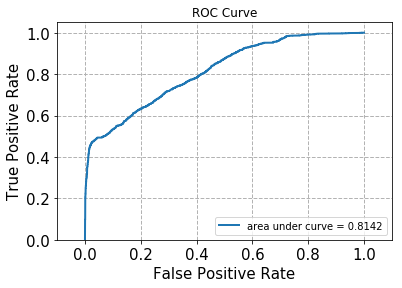

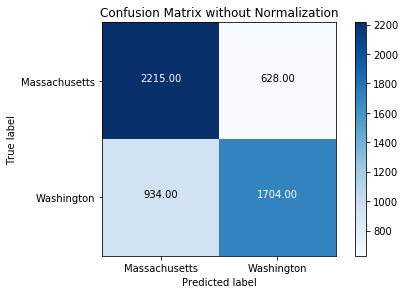

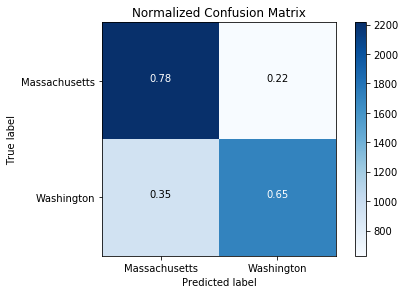

Accuracy: 0.715015508119
Recall: 0.645943896892
Precision: 0.730703259005
------------------------------
Confusion Matrix without Normalization
[[1990  362]
 [ 735 2394]]
Normalized Confusion Matrix
[[ 0.85  0.15]
 [ 0.23  0.77]]


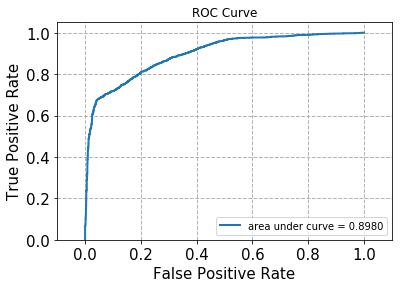

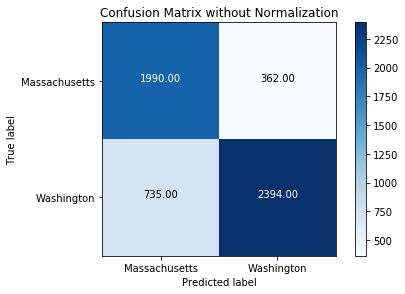

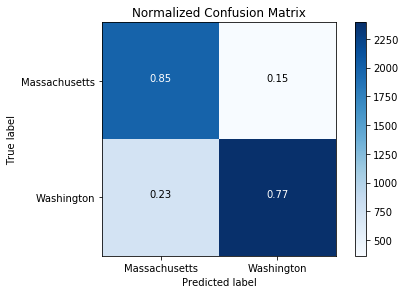

Accuracy: 0.799854041233
Recall: 0.765100671141
Precision: 0.868650217707
------------------------------
Confusion Matrix without Normalization
[[2035  584]
 [1269 1593]]
Normalized Confusion Matrix
[[ 0.78  0.22]
 [ 0.44  0.56]]


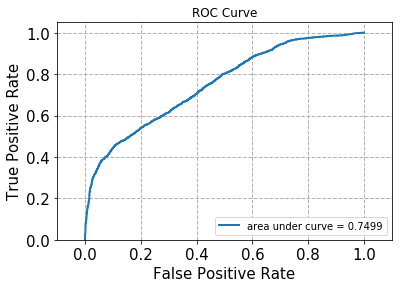

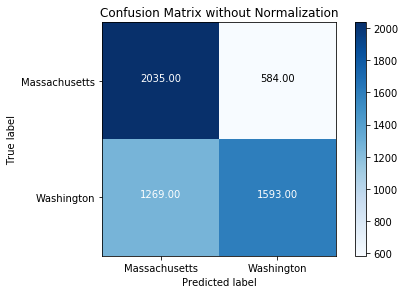

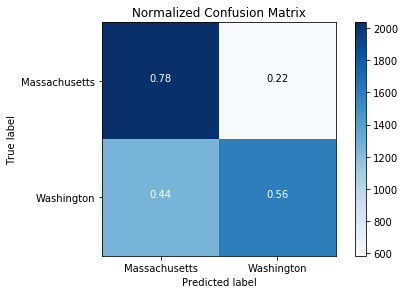

Accuracy: 0.661923006751
Recall: 0.556603773585
Precision: 0.731740927882
------------------------------
Confusion Matrix without Normalization
[[2268  684]
 [1307 1222]]
Normalized Confusion Matrix
[[ 0.77  0.23]
 [ 0.52  0.48]]


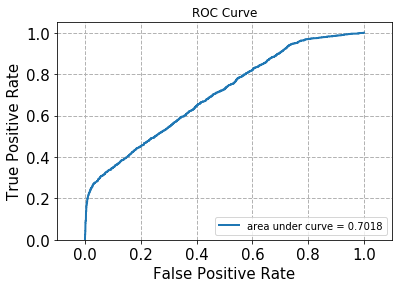

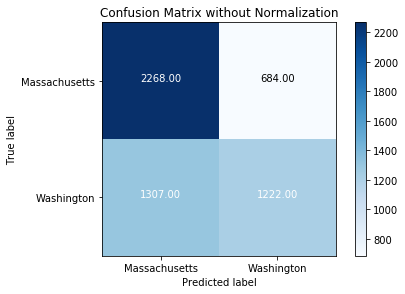

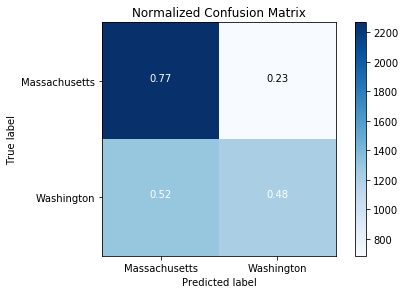

Accuracy: 0.636745119504
Recall: 0.483194938711
Precision: 0.641133263379
------------------------------
Confusion Matrix without Normalization
[[2254  348]
 [1962  917]]
Normalized Confusion Matrix
[[ 0.87  0.13]
 [ 0.68  0.32]]


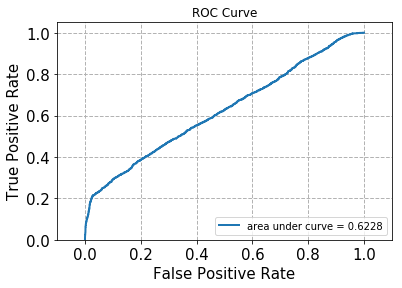

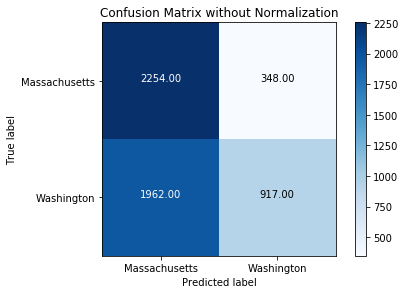

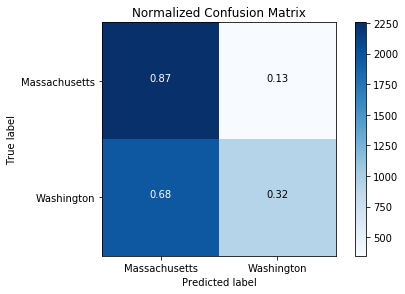

Accuracy: 0.578544061303
Recall: 0.318513372699
Precision: 0.724901185771
------------------------------
Confusion Matrix without Normalization
[[1869  597]
 [1404 1611]]
Normalized Confusion Matrix
[[ 0.76  0.24]
 [ 0.47  0.53]]


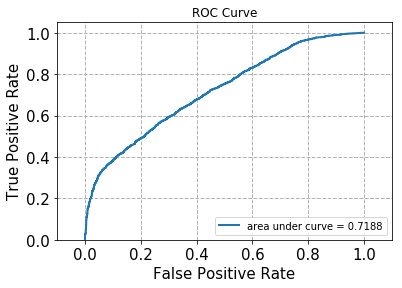

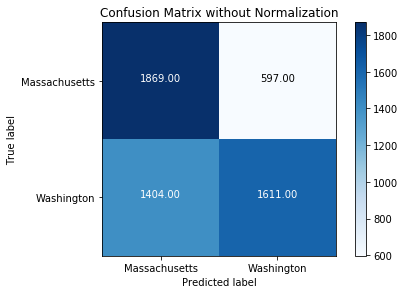

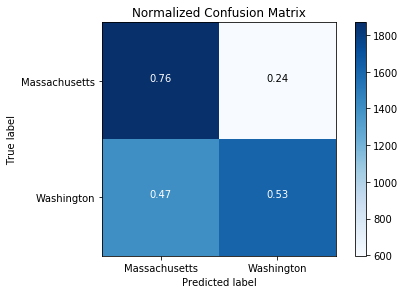

Accuracy: 0.634920634921
Recall: 0.534328358209
Precision: 0.729619565217
------------------------------
Confusion Matrix without Normalization
[[2709  522]
 [1075 1175]]
Normalized Confusion Matrix
[[ 0.84  0.16]
 [ 0.48  0.52]]


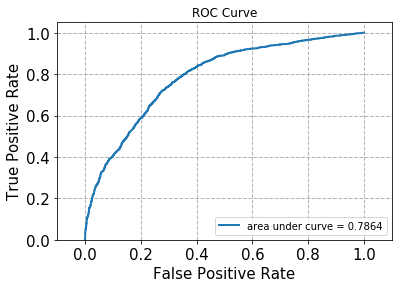

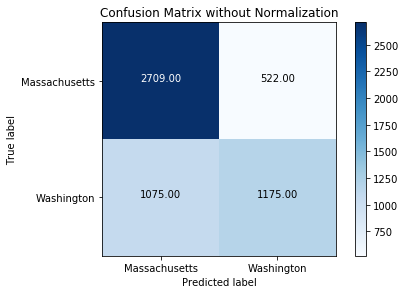

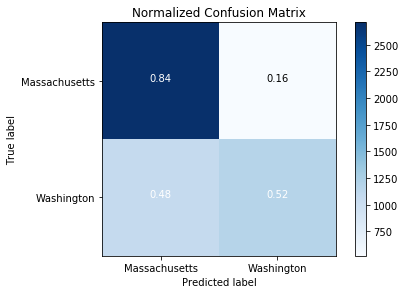

Accuracy: 0.708629812078
Recall: 0.522222222222
Precision: 0.692398350029
------------------------------
Confusion Matrix without Normalization
[[2584  972]
 [ 841 1084]]
Normalized Confusion Matrix
[[ 0.73  0.27]
 [ 0.44  0.56]]


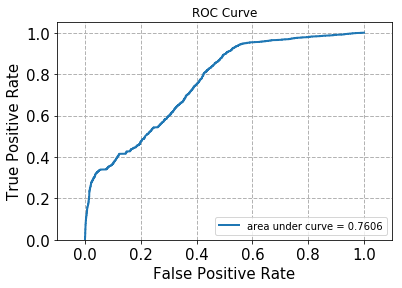

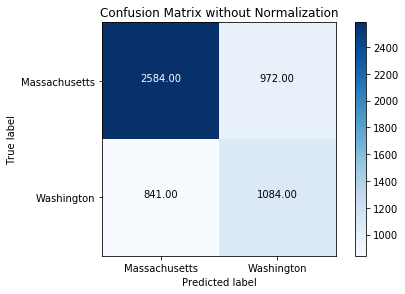

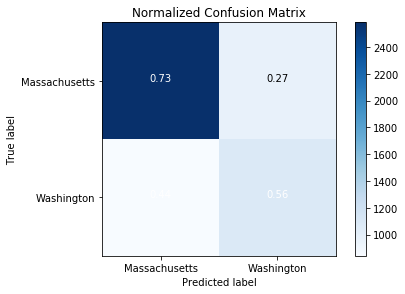

Accuracy: 0.669220945083
Recall: 0.563116883117
Precision: 0.527237354086
------------------------------
The average accuracy is 0.7106
The average recall is 0.6041
The average precision is 0.7519
Runtime：577.628


In [10]:
start = time.clock()

X = np.array(texts)
y = np.array(locations)

vect_2 = CountVectorizer(analyzer = 'word', tokenizer = stem_tokenizer, stop_words = stop_words, min_df = 2)
tfidf_transformer = TfidfTransformer()

pipe = produce_pipeline(2, LogisticRegression())

bclasses = ['Massachusetts','Washington']

accuracies = list()
recalls = list()
precisions = list()

kf = KFold(n_splits=10)
for train_index, test_index in kf.split(texts):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = list(X_train)
    y_train = list(y_train)
    X_test = list(X_test)
    y_test = list(y_test)
    
    pipe.fit(X_train, y_train)
    
    test_score = pipe.decision_function(X_test)
    
    test_predict = pipe.predict(X_test)
    
    fpr, tpr, threshold = roc_curve(y_test, test_score)
    
    plot_roc(fpr, tpr)
    compute_and_plot_confusion_matrix(y_test, test_predict)
    
    accuracy = accuracy_score(y_test, test_predict)
    accuracies.append(accuracy)
    print('Accuracy:',accuracy)
    
    recall = recall_score(y_test, test_predict)
    recalls.append(recall)
    print('Recall:',recall)
    
    precision = precision_score(y_test, test_predict)
    precisions.append(precision)
    print('Precision:',precision)
    
    print('-'*30)

print('The average accuracy is %.4f'%(sum(accuracies)/len(accuracies)))
print('The average recall is %.4f'%(sum(recalls)/len(recalls)))
print('The average precision is %.4f'%(sum(precisions)/len(precisions)))

end = time.clock()
print("Runtime：%.03f"%(end - start))

{'firstpost_date': 1419866833, 
 'title': "I'm so excited the road to #SuperBowlXLIX will go through #SEATTLE! #GoHawks #Seahawks #PNW #12thman #NFCWestChamps http://t.co/CItrDrsWBn", 
 'url': 'http://twitter.com/NWhite1005/status/549587448133873667', 
 'tweet': {'contributors': None, 
           'truncated': False, 
           'text': "I'm so excited the road to #SuperBowlXLIX will go through #SEATTLE! #GoHawks #Seahawks #PNW #12thman #NFCWestChamps http://t.co/CItrDrsWBn", 
           'in_reply_to_status_id': None, 
           'id': 549587448133873667, 
           'favorite_count': 0, 
           'source': '<a href=" " rel="nofollow">Twitter for iPhone</a >', 
           'retweeted': False, 
           'coordinates': None, 
           'timestamp_ms': '1419866833133', 
           'entities': {'symbols': [], 
                        'media': [{'expanded_url': 'http://twitter.com/NWhite1005/status/549587448133873667/photo/1', 
                                   'sizes': {'large': {'h': 610, 'resize': 'fit', 'w': 1023}, 
                                             'small': {'h': 202, 'resize': 'fit', 'w': 340}, 
                                             'medium': {'h': 357, 'resize': 'fit', 'w': 600}, 
                                             'thumb': {'h': 150, 'resize': 'crop', 'w': 150}}, 
                                   'url': 'http://t.co/CItrDrsWBn', 
                                   'media_url_https': 'https://pbs.twimg.com/media/B6CG3CcIEAEfh2X.jpg', 
                                   'id_str': '549587434644967425', 
                                   'indices': [116, 138], 
                                   'media_url': 'http://pbs.twimg.com/media/B6CG3CcIEAEfh2X.jpg', 
                                   'type': 'photo', 
                                   'id': 549587434644967425, 
                                   'display_url': 'pic.twitter.com/CItrDrsWBn'}], 
                        'hashtags': [{'indices': [27, 41], 'text': 'SuperBowlXLIX'}, 
                                     {'indices': [58, 66], 'text': 'SEATTLE'}, 
                                     {'indices': [68, 76], 'text': 'GoHawks'}, 
                                     {'indices': [77, 86], 'text': 'Seahawks'}, 
                                     {'indices': [87, 91], 'text': 'PNW'}, 
                                     {'indices': [92, 100], 'text': '12thman'},
                                     {'indices': [101, 115], 'text': 'NFCWestChamps'}], 
                        'user_mentions': [], 
                        'trends': [], 
                        'urls': []}, 
           'in_reply_to_screen_name': None, 
           'in_reply_to_user_id': None, 
           'retweet_count': 0, 
           'id_str': '549587448133873667', 
           'favorited': False, 
           'user': {'follow_request_sent': None, 
                    'profile_use_background_image': True, 
                    'geo_enabled': True, 
                    'description': "Nobody goes there anymore; It's too crowded. Tennessee by way of White Salmon, WA", 
                    'verified': False, 
                    'profile_image_url_https': 'https://pbs.twimg.com/profile_images/549379811060088832/O-y1KY_Z_normal.jpeg', 
                    'profile_sidebar_fill_color': 'DDEEF6', 
                    'is_translator': False, 
                    'id': 2374402878, 
                    'profile_text_color': '333333', 
                    'followers_count': 294, 
                    'profile_sidebar_border_color': 'FFFFFF', 
                    'id_str': '2374402878', 
                    'default_profile_image': False, 
                    'location': '#Seahawks #Mariners ', 
                    'utc_offset': None, 
                    'statuses_count': 552, 
                    'profile_background_color': '131516', 
                    'friends_count': 190, 
                    'profile_link_color': '004F99', 
                    'profile_image_url': 'http://pbs.twimg.com/profile_images/549379811060088832/O-y1KY_Z_normal.jpeg', 
                    'notifications': None, 
                    'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme14/bg.gif', 
                    'profile_banner_url': 'https://pbs.twimg.com/profile_banners/2374402878/1416587425', 
                    'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme14/bg.gif', 
                    'name': 'Nick White', 'lang': 'en', 
                    'profile_background_tile': True, 
                    'favourites_count': 13915, 
                    'screen_name': 'NWhite1005', 
                    'url': None, 
                    'created_at': 'Wed Mar 05 22:06:15 +0000 2014', 
                    'contributors_enabled': False, 
                    'time_zone': None, 
                    'protected': False, 
                    'default_profile': False, 
                    'following': None, 
                    'listed_count': 6}, 
           'geo': None, 
           'in_reply_to_user_id_str': None, 
           'possibly_sensitive': False, 
           'lang': 'en', 
           'created_at': 'Mon Dec 29 15:27:13 +0000 2014', 
           'filter_level': 'medium', 
           'in_reply_to_status_id_str': None, 
           'place': None, 
           'extended_entities': {'media': [{'expanded_url': 'http://twitter.com/NWhite1005/status/549587448133873667/photo/1', 
                                            'sizes': {'large': {'h': 610, 'resize': 'fit', 'w': 1023}, 
                                                      'small': {'h': 202, 'resize': 'fit', 'w': 340}, 
                                                      'medium': {'h': 357, 'resize': 'fit', 'w': 600}, 
                                                      'thumb': {'h': 150, 'resize': 'crop', 'w': 150}}, 
                                            'url': 'http://t.co/CItrDrsWBn', 
                                            'media_url_https': 'https://pbs.twimg.com/media/B6CG3CcIEAEfh2X.jpg', 
                                            'id_str': '549587434644967425', 
                                            'indices': [116, 138], 
                                            'media_url': 'http://pbs.twimg.com/media/B6CG3CcIEAEfh2X.jpg', 
                                            'type': 'photo', 
                                            'id': 549587434644967425, 
                                            'display_url': 'pic.twitter.com/CItrDrsWBn'}]}}, 
 'author': {'author_img': 'http://pbs.twimg.com/profile_images/493543351644196867/IabHFMxa_normal.jpeg', 
            'name': 'Id Ego Superego', 
            'url': 'http://twitter.com/theuntrainedeye', 
            'nick': 'theuntrainedeye', 
            'followers': 199.0, 
            'image_url': 'http://pbs.twimg.com/profile_images/493543351644196867/IabHFMxa_normal.jpeg', 
            'type': 'twitter', 
            'influence_level': 0.0, 
            'description': 'A Somewhat Beautiful State of Mind.'}, 
 'original_author': {'author_img': 'http://pbs.twimg.com/profile_images/566991435564462080/lmMuu0h7_normal.jpeg', 
                     'description': "Nobody goes there anymore; It's too crowded. Hendersonville, Tennessee by way of White Salmon, WA #PNW", 
                     'url': 'http://twitter.com/nwhite1005', 
                     'nick': 'nwhite1005', 
                     'followers': 527.0, 
                     'image_url': 'http://pbs.twimg.com/profile_images/566991435564462080/lmMuu0h7_normal.jpeg', 
                     'type': 'twitter', 'name': 'Nick '}, 
 'citation_date': 1421367835, 
 'metrics': {'acceleration': 0, 
             'ranking_score': 4.1343412, 
             'citations': {'influential': 0, 
                           'total': 7, 
                           'data': [{'timestamp': 1421367779, 'citations': 1}], 
                           'matching': 1, 'replies': 0}, 
             'peak': 1421367839, 
             'impressions': 183, 
             'momentum': 1}, 
 'highlight': "I'm so excited the road to #SuperBowlXLIX will go through #SEATTLE! #GoHawks #Seahawks #PNW #12thman #NFCWestChamps http://t.co/CItrDrsWBn", 
 'type': 'retweet:native', 
 'citation_url': 'http://twitter.com/TheUntrainedEye/status/555883108612833281'}

In [11]:
from sklearn.ensemble import RandomForestClassifier

Confusion Matrix without Normalization
[[1283  261]
 [ 396 3542]]
Normalized Confusion Matrix
[[ 0.83  0.17]
 [ 0.1   0.9 ]]


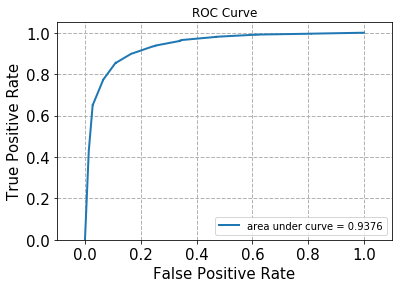

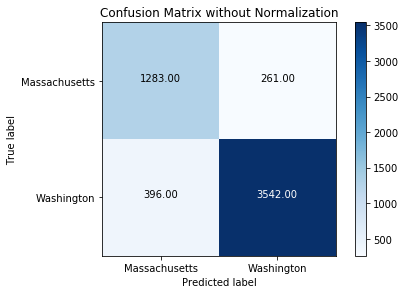

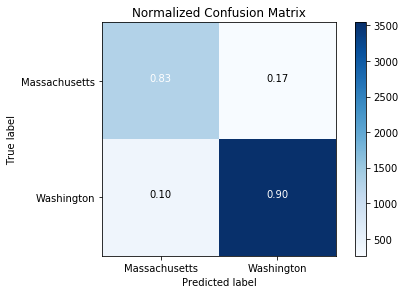

Accuracy: 0.880153228749
Recall: 0.899441340782
Precision: 0.931369971075
------------------------------
Confusion Matrix without Normalization
[[1739  357]
 [ 685 2701]]
Normalized Confusion Matrix
[[ 0.83  0.17]
 [ 0.2   0.8 ]]


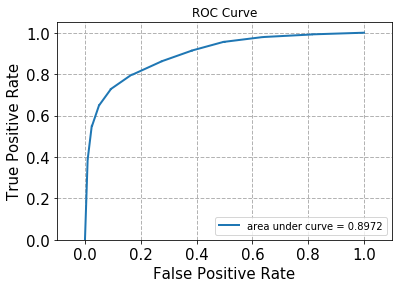

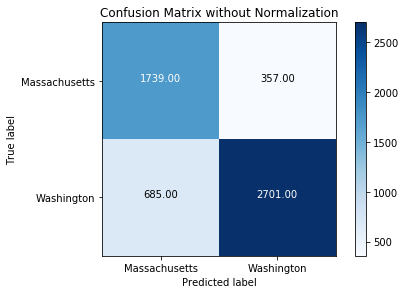

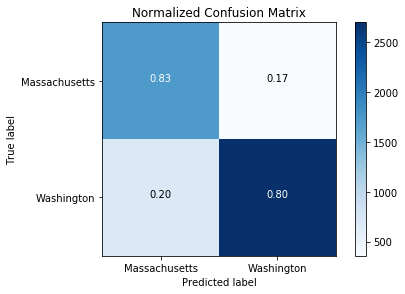

Accuracy: 0.809923385626
Recall: 0.797696396929
Precision: 0.883257030739
------------------------------
Confusion Matrix without Normalization
[[2171  672]
 [ 767 1871]]
Normalized Confusion Matrix
[[ 0.76  0.24]
 [ 0.29  0.71]]


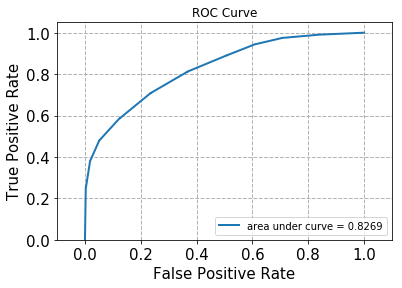

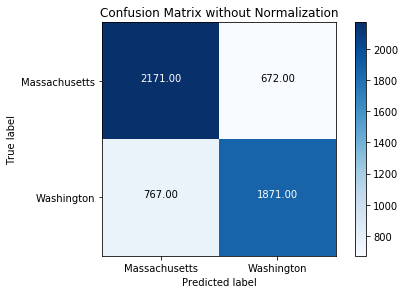

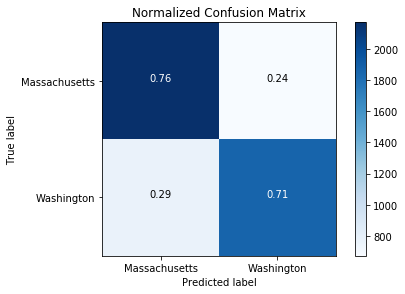

Accuracy: 0.737456668491
Recall: 0.709249431387
Precision: 0.735745182855
------------------------------
Confusion Matrix without Normalization
[[1896  456]
 [ 686 2443]]
Normalized Confusion Matrix
[[ 0.81  0.19]
 [ 0.22  0.78]]


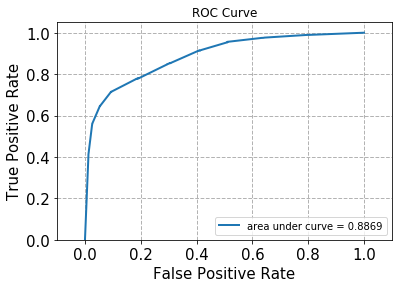

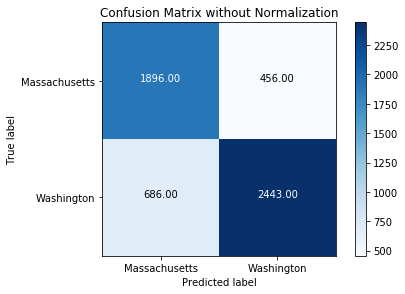

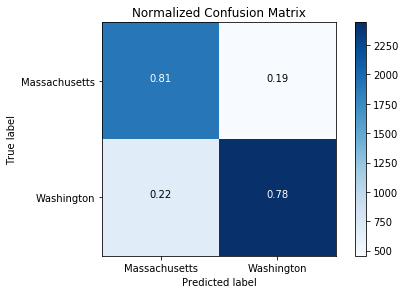

Accuracy: 0.791643860609
Recall: 0.780760626398
Precision: 0.842704380821
------------------------------
Confusion Matrix without Normalization
[[1902  717]
 [1132 1730]]
Normalized Confusion Matrix
[[ 0.73  0.27]
 [ 0.4   0.6 ]]


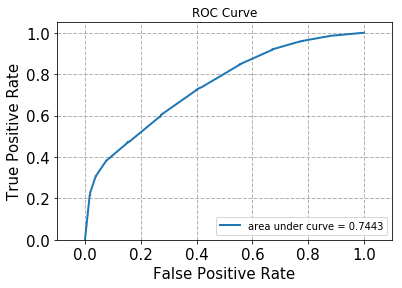

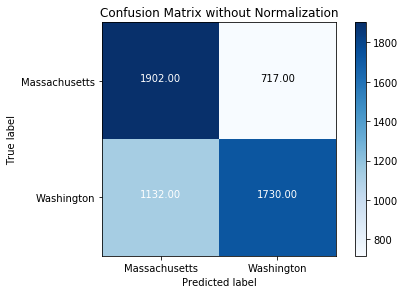

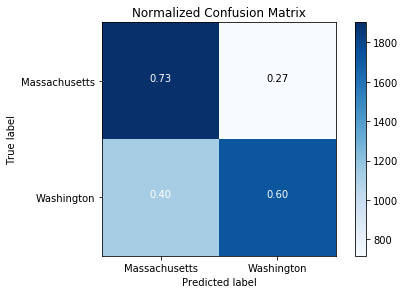

Accuracy: 0.662652800584
Recall: 0.604472396925
Precision: 0.706988148754
------------------------------
Confusion Matrix without Normalization
[[2135  817]
 [1153 1376]]
Normalized Confusion Matrix
[[ 0.72  0.28]
 [ 0.46  0.54]]


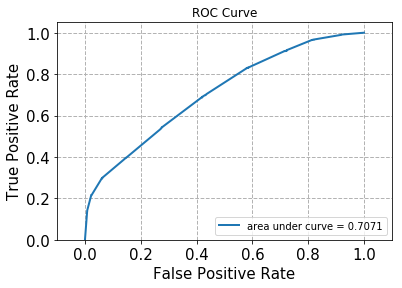

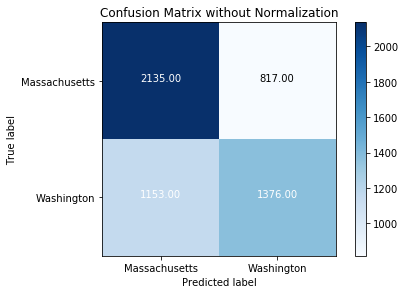

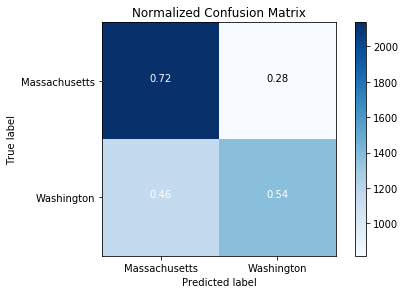

Accuracy: 0.640576537128
Recall: 0.544088572558
Precision: 0.627450980392
------------------------------
Confusion Matrix without Normalization
[[1634  968]
 [1303 1576]]
Normalized Confusion Matrix
[[ 0.63  0.37]
 [ 0.45  0.55]]


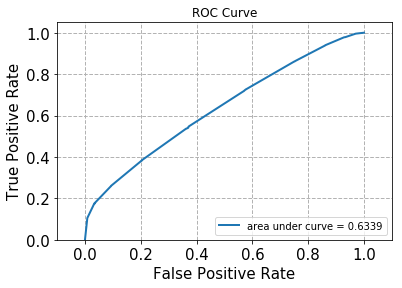

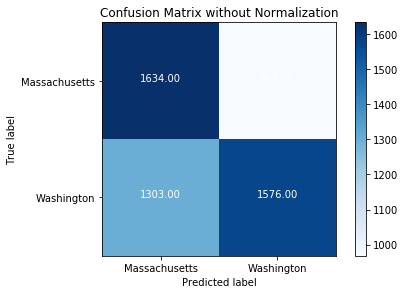

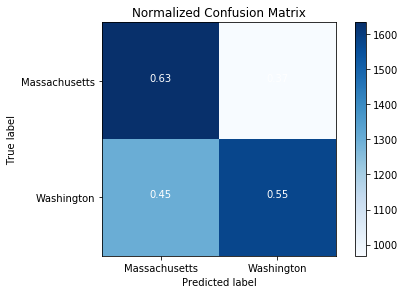

Accuracy: 0.585659551177
Recall: 0.547412295936
Precision: 0.619496855346
------------------------------
Confusion Matrix without Normalization
[[1733  733]
 [1303 1712]]
Normalized Confusion Matrix
[[ 0.7   0.3 ]
 [ 0.43  0.57]]


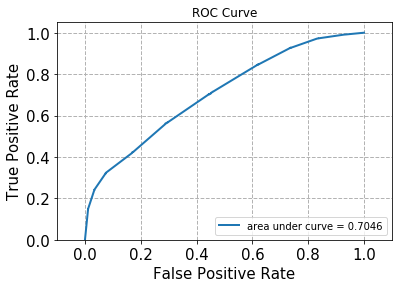

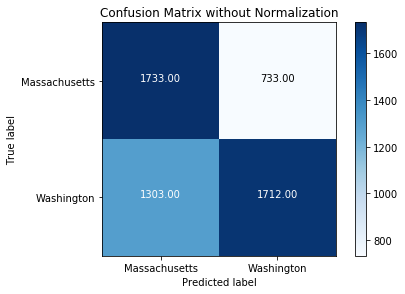

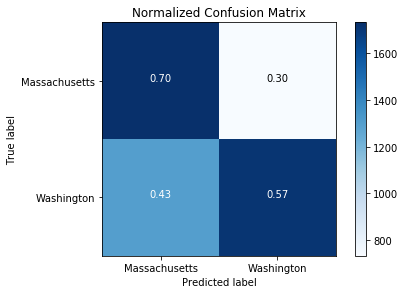

Accuracy: 0.62853493888
Recall: 0.567827529022
Precision: 0.700204498978
------------------------------
Confusion Matrix without Normalization
[[2653  578]
 [1039 1211]]
Normalized Confusion Matrix
[[ 0.82  0.18]
 [ 0.46  0.54]]


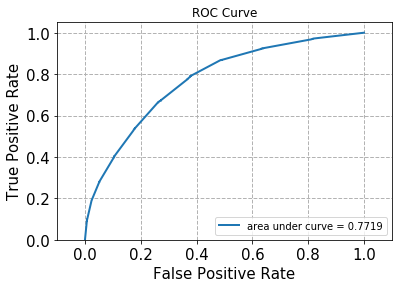

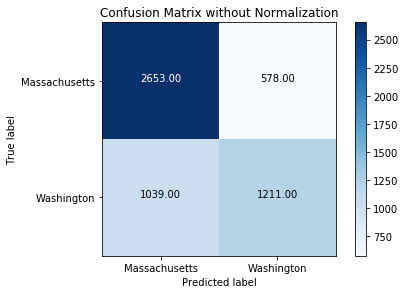

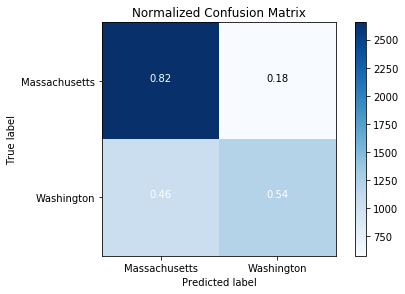

Accuracy: 0.704980842912
Recall: 0.538222222222
Precision: 0.676914477362
------------------------------
Confusion Matrix without Normalization
[[2911  645]
 [ 834 1091]]
Normalized Confusion Matrix
[[ 0.82  0.18]
 [ 0.43  0.57]]


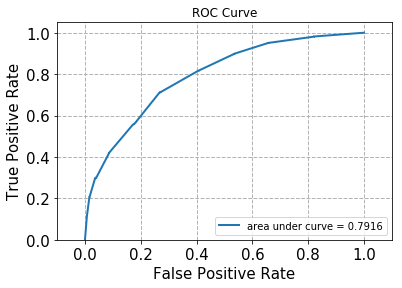

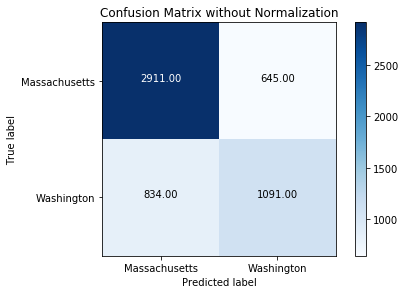

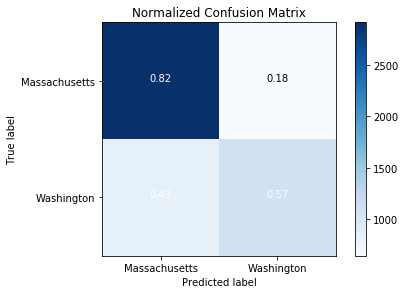

Accuracy: 0.730158730159
Recall: 0.566753246753
Precision: 0.628456221198
------------------------------
The average accuracy is 0.7172
The average recall is 0.6556
The average precision is 0.7353
Runtime：648.056


In [12]:
start = time.clock()

X = np.array(texts)
y = np.array(locations)

vect_2 = CountVectorizer(analyzer = 'word', tokenizer = stem_tokenizer, stop_words = stop_words, min_df = 2)
tfidf_transformer = TfidfTransformer()

pipe = produce_pipeline(2, RandomForestClassifier())

bclasses = ['Massachusetts','Washington']

accuracies = list()
recalls = list()
precisions = list()

kf = KFold(n_splits=10)
for train_index, test_index in kf.split(texts):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = list(X_train)
    y_train = list(y_train)
    X_test = list(X_test)
    y_test = list(y_test)
    
    pipe.fit(X_train, y_train)
    
    test_score = pipe.predict_proba(X_test)
    
    test_predict = pipe.predict(X_test)
    
    fpr, tpr, threshold = roc_curve(y_test, test_score[:,1])
    
    plot_roc(fpr, tpr)
    compute_and_plot_confusion_matrix(y_test, test_predict)
    
    accuracy = accuracy_score(y_test, test_predict)
    accuracies.append(accuracy)
    print('Accuracy:',accuracy)
    
    recall = recall_score(y_test, test_predict)
    recalls.append(recall)
    print('Recall:',recall)
    
    precision = precision_score(y_test, test_predict)
    precisions.append(precision)
    print('Precision:',precision)
    
    print('-'*30)

print('The average accuracy is %.4f'%(sum(accuracies)/len(accuracies)))
print('The average recall is %.4f'%(sum(recalls)/len(recalls)))
print('The average precision is %.4f'%(sum(precisions)/len(precisions)))

end = time.clock()
print("Runtime：%.03f"%(end - start))